In [54]:
%reload_ext autoreload

In [55]:
# Packages needed

#!pip install "tabulate" "pandas_summary" "imblearn" "joblib"
#!pip install fastai==0.7.0
#!pip install eli5
#!pip install ggplot
#!pip install pdp

In [56]:
# Imports

%load_ext autoreload
%autoreload 2

%matplotlib inline
import sys
from pandas import Timestamp
import pandas as pd
from fastai.imports import *
from fastai.structured import *
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals import joblib
from sklearn.model_selection import GridSearchCV

#import numpy as np
#import random
#from matplotlib import pyplot
#from pandas_summary import DataFrameSummary
#from IPython.display import display
#from tabulate import tabulate
#from sklearn.model_selection import GridSearchCV
#from scipy.stats.mstats import mode, gmean, hmean
#from sklearn import metrics

#set_plot_sizes(12,14,16)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
sys.path.append('../lib')
import utils
import preprocessing

In [58]:
# Load in data

PATH = "../data/"
df_raw = pd.read_csv(f'{PATH}churn.csv', low_memory=False, 
                     parse_dates=['canceldate', 'licence_registration_date', 'golive_date'])

In [59]:
print(len(df_raw), df_raw.shape)
df_processed = preprocessing.prepare_data(df_raw.loc[df_raw.licence_status != "STAGING"])
print(len(df_processed), df_processed.shape)

5889 (5889, 38)
Sorting dataframe by licence_registration_date ...
Converting annual_revenue to a number ...
Defaulting all NaN values with median ...
Defaulting annual_revenue for missing values to the plans mean or platform medeian ...
Binning last_login_days
Binning NPS data
Fixing days_active abnormal values ...
One-hot encoding customer_account_status
One-hot encoding plan
One-hot encoding nps
Preprocessing dates ...
Dropping features ...
Replacing NaN values with median and adding '_was_nan' column ...
Convert categorical features into numbers ...
List any features that still have NaN values ...
Feature has NaN values: last_login_categories
5547 (5547, 141)


In [60]:
utils.display_all(df_processed[df_processed.last_login_categories.isna()])

,username,days_active,team,vertical,salesperson,golive_days,cases_total,cases_open,cases_closed,cases_age_hours_total,cases_age_hours_average,annual_revenue,interactions_total,interactions_completed,interactions_no_response,interactions_no_onboarding,interactions_completed_training,churn_concern_cases_total,churn_concern_cases_open,churn_concern_cases_avg_hours,churned,cases_totalwas_nan,cases_openwas_nan,cases_closedwas_nan,cases_age_hours_totalwas_nan,cases_age_hours_averagewas_nan,last_login_dayswas_nan,annual_revenue_was_missing,last_login_categories,days_active_modified,customer_account_status_PoorStanding,plan_BASIC,plan_BRONZE,plan_BUSINESS,plan_BUSINESS +,plan_BUSINESS ONE,plan_CUSTOM,plan_CUSTOM XL,plan_ENTERPRISE,plan_GOLD,plan_GROW,plan_L&S - PREMIUM,plan_L&S - STANDARD,plan_L&S - ULTIMATE,plan_LIST N SEND SILVER,plan_LISTNSEND,plan_NETO XL,plan_PLAN-360-17Q2,plan_PLAN-360-19Q1,plan_PLAN-360-TRANSITION,plan_PLAN-360-US,plan_PLAN-L,plan_PLAN-L-17Q2,plan_PLAN-L-19Q1,plan_PLAN-M,plan_PLAN-M-17Q2,plan_PLAN-M-19Q1,plan_PLAN-M-US,plan_PLAN-S,plan_PLAN-S-17Q2,plan_PLAN-S-19Q1,plan_PLAN-S-US,plan_PLAN-XL-19Q1,plan_PLAN-XS,plan_PLAN-XS-17Q2,plan_PREMIUM,plan_STANDARD,plan_START,plan_START - LEGACY,plan_TRIAL,plan_ULTIMATE,plan_ULTIMATE PLUS,nps_no_data,nps_detractor,nps_passive,nps_promoter,licence_registration_Year,licence_registration_Month,licence_registration_Week,licence_registration_Day,licence_registration_Dayofweek,licence_registration_Dayofyear,licence_registration_Is_month_end,licence_registration_Is_month_start,licence_registration_Is_quarter_end,licence_registration_Is_quarter_start,licence_registration_Is_year_end,licence_registration_Is_year_start,licence_registration_Elapsed,golive_Year,golive_Month,golive_Week,golive_Day,golive_Dayofweek,golive_Dayofyear,golive_Is_month_end,golive_Is_month_start,golive_Is_quarter_end,golive_Is_quarter_start,golive_Is_year_end,golive_Is_year_start,golive_Elapsed,days_active_was_nan,golive_days_was_nan,cases_total_was_nan,cases_open_was_nan,cases_closed_was_nan,cases_age_hours_total_was_nan,cases_age_hours_average_was_nan,annual_revenue_was_nan,interactions_total_was_nan,interactions_completed_was_nan,interactions_no_response_was_nan,interactions_no_onboarding_was_nan,interactions_completed_training_was_nan,churn_concern_cases_total_was_nan,churn_concern_cases_open_was_nan,churn_concern_cases_avg_hours_was_nan,churned_was_nan,cases_totalwas_nan_was_nan,cases_openwas_nan_was_nan,cases_closedwas_nan_was_nan,cases_age_hours_totalwas_nan_was_nan,cases_age_hours_averagewas_nan_was_nan,last_login_dayswas_nan_was_nan,annual_revenue_was_missing_was_nan,days_active_modified_was_nan,licence_registration_Year_was_nan,licence_registration_Month_was_nan,licence_registration_Week_was_nan,licence_registration_Day_was_nan,licence_registration_Dayofweek_was_nan,licence_registration_Dayofyear_was_nan,licence_registration_Elapsed_was_nan,golive_Year_was_nan,golive_Month_was_nan,golive_Week_was_nan,golive_Day_was_nan,golive_Dayofweek_was_nan,golive_Dayofyear_was_nan,golive_Elapsed_was_nan
0,NoveltyShop,1851,not specified,not specified,dominic,-1,5,0,0,1159,249,6.172918e+04,2.0,2.0,0.0,0.0,0.0,1.0,0.0,404.0,1,1,1,1,1,1,1,1,NaN,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2010,7,26,3,5,184,False,False,False,False,False,False,1278115200,1970,1,1,1,3,1,False,True,False,True,False,True,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,N002341,2269,Neto XL,Sports & Recreation,not specified,-1,22,1,1,4795,217,3.684476e+07,1.0,1.0,0.0,0.0,0.0,1.0,0.0,404.0,0,1,1,1,1,1,1,1,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,2013,7,29,16,1,197,False,False,False,False,False,False,1373932800,1970,1,1,1,3,1,False,True,False,True,False,True,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,N001714,2268,not specified,Health & Beauty,cat,-1,4,0,0,170,42,5.5

In [61]:
#df_filtered = df_processed.loc[df_processed.licence_registration_Year > 2015]
df_filtered = df_processed

In [62]:
df_trn, y_trn, nas = proc_df(df_filtered, 'churned')
print(len(df_trn), df_trn.shape)

5547 (5547, 140)


In [63]:
def split_vals(a,n): return a[:n], a[n:]

n_valid = 500
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)

In [64]:
X_train.shape, y_train.shape

((5047, 140), (5047,))

In [65]:
# Fix the dataset imbalance

sm = SMOTE(random_state=12, ratio = 1.0)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

In [66]:
X_train_res.shape, y_train_res.shape

((5916, 140), (5916,))

In [67]:
# Show any features with NaN values
preprocessing.features_with_nan(df_filtered)

Feature has NaN values: last_login_categories


In [68]:
X_train.shape, y_train.shape

((5047, 140), (5047,))

In [69]:
m = RandomForestClassifier(
    n_estimators=2000,
    min_samples_leaf=3, 
    max_features='sqrt',
    n_jobs=-1,
    max_depth=3,
    bootstrap=False,
    criterion='entropy',
    class_weight={0: 4, 1: 1}
    )

m.fit(X_train_res, y_train_res)
#m.fit(X_train, y_train)

y_pred = m.predict(X_valid)
print(utils.uber_score(y_valid, y_pred))
utils.conf_matrix(y_valid, y_pred)

# Save to file in the current working directory
joblib_file = "churn_model.pkl"
joblib.dump(m, joblib_file)

0.8725490196078431 0.5894039735099338 0.7035573122529644 0.85 0.608134091289082 0.15
None
tp, fn, fp, tn
[[336  13]
 [ 62  89]]


['churn_model.pkl']

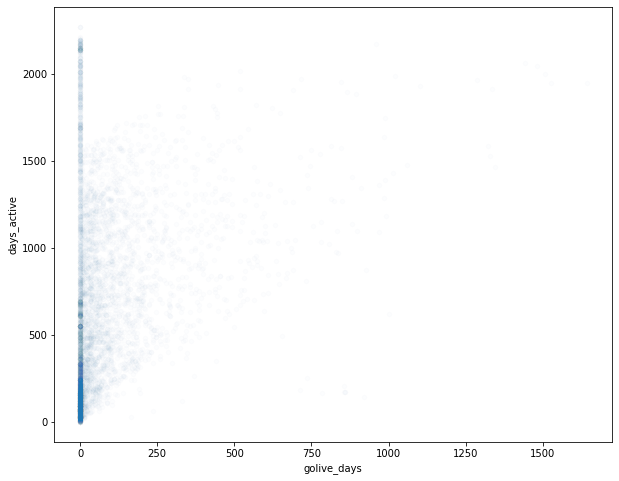

In [45]:
df_filtered.plot('golive_days', 'days_active', 'scatter', alpha=0.01, figsize=(10,8));

In [46]:
X_train.columns

Index(['days_active', 'team', 'vertical', 'salesperson', 'golive_days',
       'cases_total', 'cases_open', 'cases_closed', 'cases_age_hours_total',
       'cases_age_hours_average',
       ...
       'licence_registration_Dayofweek_was_nan',
       'licence_registration_Dayofyear_was_nan',
       'licence_registration_Elapsed_was_nan', 'golive_Year_was_nan',
       'golive_Month_was_nan', 'golive_Week_was_nan', 'golive_Day_was_nan',
       'golive_Dayofweek_was_nan', 'golive_Dayofyear_was_nan',
       'golive_Elapsed_was_nan'],
      dtype='object', length=139)

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1c29bb65f8>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1c2b6e26d8>})

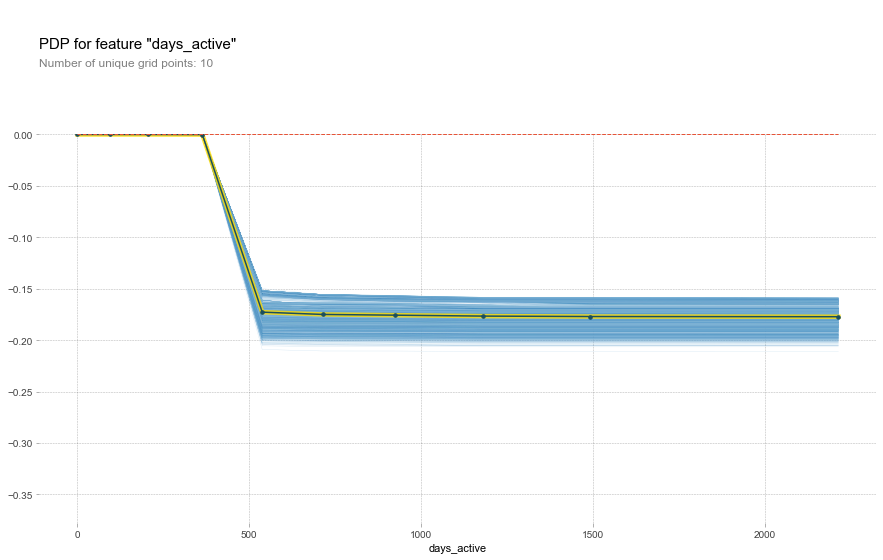

In [47]:
from pdpbox import pdp

x = get_sample(X_train, 2000)

def plot_pdp(feat, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, x, x.columns,feat)
    return pdp.pdp_plot(p, feat_name, plot_lines=True,
                        cluster=clusters is not None,
                        n_cluster_centers=clusters)

plot_pdp('days_active')

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1c31ee4710>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1c31eddbe0>})

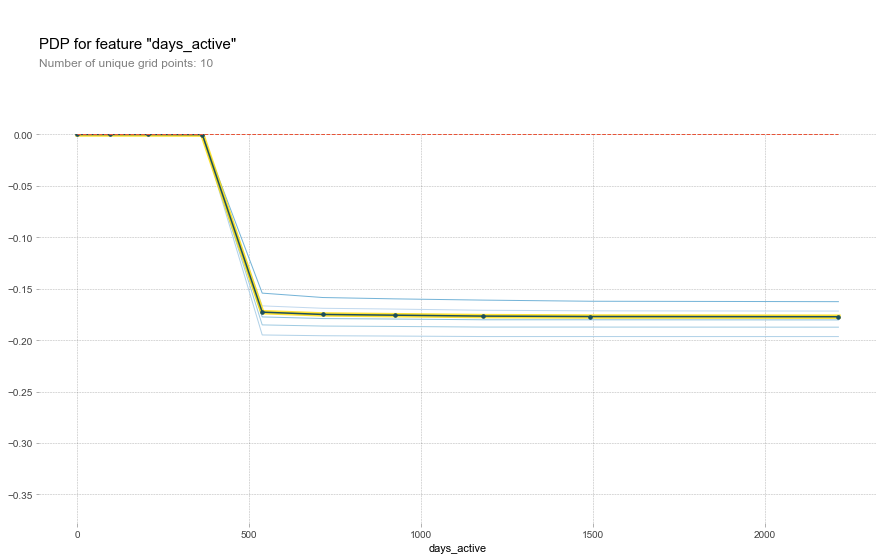

In [48]:
plot_pdp('days_active', clusters=5)

In [49]:
fi = rf_feat_importance(m, X_valid); fi[:10]

,cols,imp
0,days_active,0.161441
5,cases_total,0.079757
10,annual_revenue,0.079405
7,cases_closed,0.075797
6,cases_open,0.072987
8,cases_age_hours_total,0.068696
58,plan_PLAN-S-19Q1,0.057693
64,plan_STANDARD,0.032978
4,golive_days,0.031751
56,plan_PLAN-S,0.031098


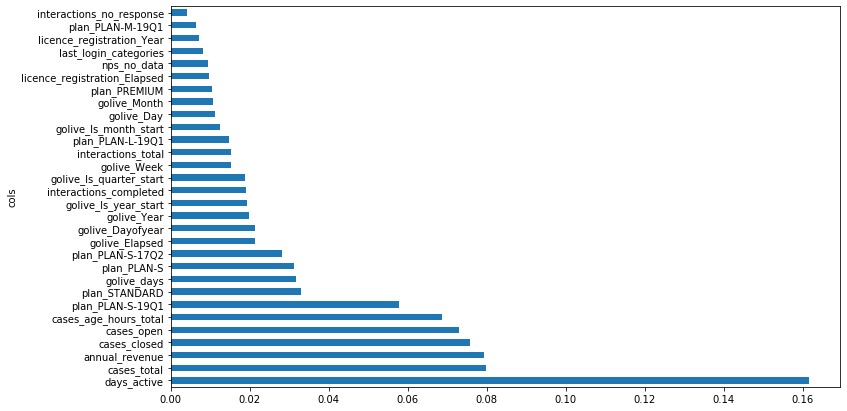

In [50]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)
plot_fi(fi[:30]);

In [51]:
to_keep = fi[fi.imp<0.17].cols; len(to_keep)
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [52]:
m = RandomForestClassifier(
    n_estimators=2000,
    min_samples_leaf=3, 
    max_features='sqrt',
    n_jobs=-1, 
    max_depth=3,
    bootstrap=False,
    criterion='entropy',
    class_weight={0: 4, 1: 1}
    )

m.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, class_weight={0: 4, 1: 1},
                       criterion='entropy', max_depth=3, max_features='sqrt',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=3,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=2000, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

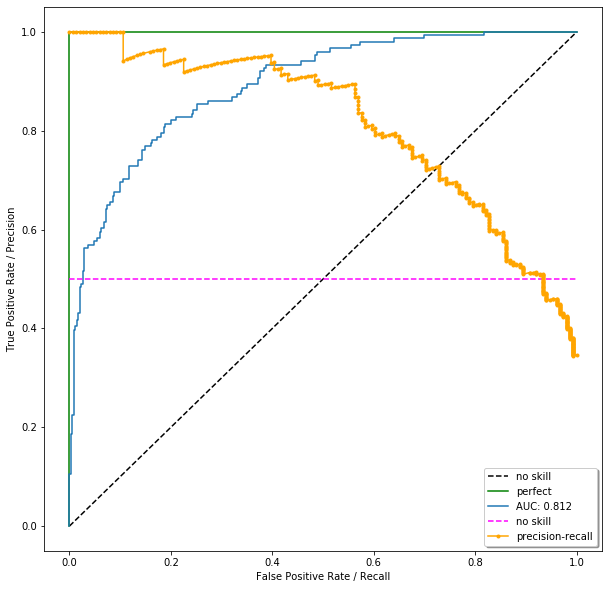

auc=0.812 ap=0.812


In [53]:
utils.plot_roc_pr(m, X_valid, y_valid)

In [27]:
#from scipy.cluster import hierarchy as hc
#corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
#corr_condensed = hc.distance.squareform(1-corr)
#z = hc.linkage(corr_condensed, method='average')
#fig = plt.figure(figsize=(10,10))
#dendrogram = hc.dendrogram(z, labels=df_trn.columns, orientation='left', leaf_font_size=16)
#plt.show()

In [28]:
print("precision, recall, f1_score, accuracy, cohen_kappa_score, mean abs error")

for column in df_keep.columns:
    m = RandomForestClassifier(
        n_estimators=200,
        min_samples_leaf=2, 
        max_features='sqrt',
        n_jobs=-1, 
        max_depth=3,
        bootstrap=False,
        criterion='entropy',
        class_weight={0: 4, 1: 1}
        )

    x, _ = split_vals(df_keep.drop(columns=[column]), n_trn)
    m.fit(x, y_train)
    y_pred = m.predict(x)
    print(column, utils.uber_score(y_train, y_pred))

precision, recall, f1_score, accuracy, cohen_kappa_score, mean abs error
0.9893679858239811 0.566260987153482 0.7202752096323372 0.7422231028333663 0.5120939077081568 0.25777689716663366
days_active None
0.9939516129032258 0.6666666666666666 0.7980574666127074 0.8022587675847038 0.6185586746768064 0.1977412324152962
cases_open None
0.9925714285714285 0.5872210953346856 0.737892948173322 0.7554983158311869 0.5355109038626591 0.24450168416881315
cases_total None
0.9961464354527938 0.6991210277214334 0.8216130313865712 0.8220725183277194 0.6546885930967372 0.17792748167228056
annual_revenue None
0.9930595720069404 0.5804597701149425 0.732664817580542 0.7517337031900139 0.5290001694407153 0.24826629680998613
cases_age_hours_total None
0.9945273631840796 0.6757944557133199 0.8047504025764896 0.8078066177927482 0.6286250024274909 0.19219338220725182
cases_closed None
0.9948132780082988 0.6484110885733604 0.7851002865329513 0.7919556171983356 0.6001575119925961 0.20804438280166435
plan_PLAN-S

0.9954568399798082 0.6666666666666666 0.798542215023284 0.8028531801069942 0.6197803572308751 0.19714681989300575
churn_concern_cases_open None
0.9936492427943332 0.6876267748478702 0.8127872127872128 0.8143451555379433 0.6403822669235858 0.18565484446205666
plan_NETO XL None
0.9952584163110479 0.7096010818120352 0.8284981251233472 0.827818506043194 0.6651083645348821 0.17218149395680601
licence_registration_Is_quarter_start None
0.995147986414362 0.6933739012846518 0.8172942817294283 0.8183079056865464 0.6477323023710504 0.18169209431345354
churn_concern_cases_total None
0.9926315789473684 0.6375929682217715 0.7764512144915603 0.78482266693085 0.587206465829076 0.21517733306915
licence_registration_Is_month_end None
0.9943705220061413 0.6568627450980392 0.7911237785016287 0.7967109173766594 0.6086295820421737 0.2032890826233406
licence_registration_Is_quarter_end None
0.9960629921259843 0.6842461122379987 0.8112224448897795 0.8133544680007926 0.6388212973453755 0.18664553199920744
cas

0.9956140350877193 0.6906693711967545 0.8155688622754491 0.8169209431345353 0.6452544143629337 0.18307905686546463
plan_CUSTOM XL None
0.9952516619183286 0.7085868830290737 0.8278041074249606 0.8272240935209035 0.6640191185344249 0.1727759064790965
plan_ENTERPRISE None
0.9960861056751468 0.6883029073698445 0.8140743702518992 0.8157321180899544 0.6431395924362816 0.18426788191004556
plan_GOLD None
0.992964824120603 0.6680189317106153 0.7987065481002426 0.8026550425995641 0.6191727155341827 0.1973449574004359
plan_L&S - PREMIUM None
0.9943705220061413 0.6568627450980392 0.7911237785016287 0.7967109173766594 0.6086295820421737 0.2032890826233406
cases_open_was_nan None
0.9958355023425299 0.6467207572684246 0.7841770854683336 0.7913612046760452 0.5991990604296017 0.20863879532395482
plan_L&S - STANDARD None
0.9966183574879227 0.6974306964164977 0.8206046141607001 0.8212799682979988 0.6532881915852589 0.17872003170200118
plan_L&S - ULTIMATE None
0.9966442953020134 0.7028397565922921 0.82434